In [105]:
# https://www.kaggle.com/competitions/playground-series-s4e2/data?select=train.csv

In [395]:
import numpy as np
import pandas as pd
import os
import datetime as dt
from copy import deepcopy
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, 
    f1_score, auc, classification_report, roc_curve, ConfusionMatrixDisplay,
)
from sklearn.preprocessing import label_binarize
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

In [107]:
df = pd.read_csv('obesity/train.csv')

In [108]:
def format_feature_name(feature):
    """
    Rename feature to follow coding standards.

    Arguments:
        feature (str): raw feature name.

    Returns:
        processed feature name as a string.
    """
    feature = feature.strip().replace('&', 'and').replace('/', '_').replace(' ', '_').lower()

    return feature

df.columns = [format_feature_name(feature=col) for col in df.columns]

<h2>EDA</h2>

In [110]:
df.head()

,id,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [111]:
#| Abbreviation   | Full Form                                 |
#|:---------------|:------------------------------------------|
#| FAVC           | Frequent consumption of high caloric food |
#| FCVC           | Frequency of consumption of vegetables    |
#| NCP            | Number of main meals                      |
#| CAEC           | Consumption of food between meals         |
#| CH20           | Consumption of water daily                |
#| CALC           | Consumption of alcohol                    |
#| SCC            | Calories consumption monitoring           |
#| FAF            | Physical activity frequency               |
#| TUE            | Time using technology devices             |
#| MTRANS         | Transportation used                       |

In [112]:
(df['id'] == df.index).value_counts()

True    20758
Name: count, dtype: int64

In [113]:
df = df.drop(columns=['id'])

In [114]:
df['bmi'] = df['weight'] / (df['height'] ** 2)

In [115]:
df['nobeyesdad'].value_counts()

nobeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64

In [116]:
target_mapping = {
    'Insufficient_Weight': '1_Insufficient_Weight',
    'Normal_Weight': '2_Normal_Weight',
    'Overweight_Level_I': '3_Overweight_Level_I',
    'Overweight_Level_II': '4_Overweight_Level_II',
    'Obesity_Type_I': '5_Obesity_Type_I',
    'Obesity_Type_II': '6_Obesity_Type_II',
    'Obesity_Type_III': '7_Obesity_Type_III',
}
df['nobeyesdad'] = df['nobeyesdad'].map(target_mapping)

In [117]:
df.isnull().sum()

gender                            0
age                               0
height                            0
weight                            0
family_history_with_overweight    0
favc                              0
fcvc                              0
ncp                               0
caec                              0
smoke                             0
ch2o                              0
scc                               0
faf                               0
tue                               0
calc                              0
mtrans                            0
nobeyesdad                        0
bmi                               0
dtype: int64

In [118]:
df.duplicated().any()

False

In [119]:
df.describe()

,age,height,weight,fcvc,ncp,ch2o,faf,tue,bmi
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756,30.241842
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113,8.333932
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.868541
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000,24.088223
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887,29.384757
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000,37.011168
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000,54.997991


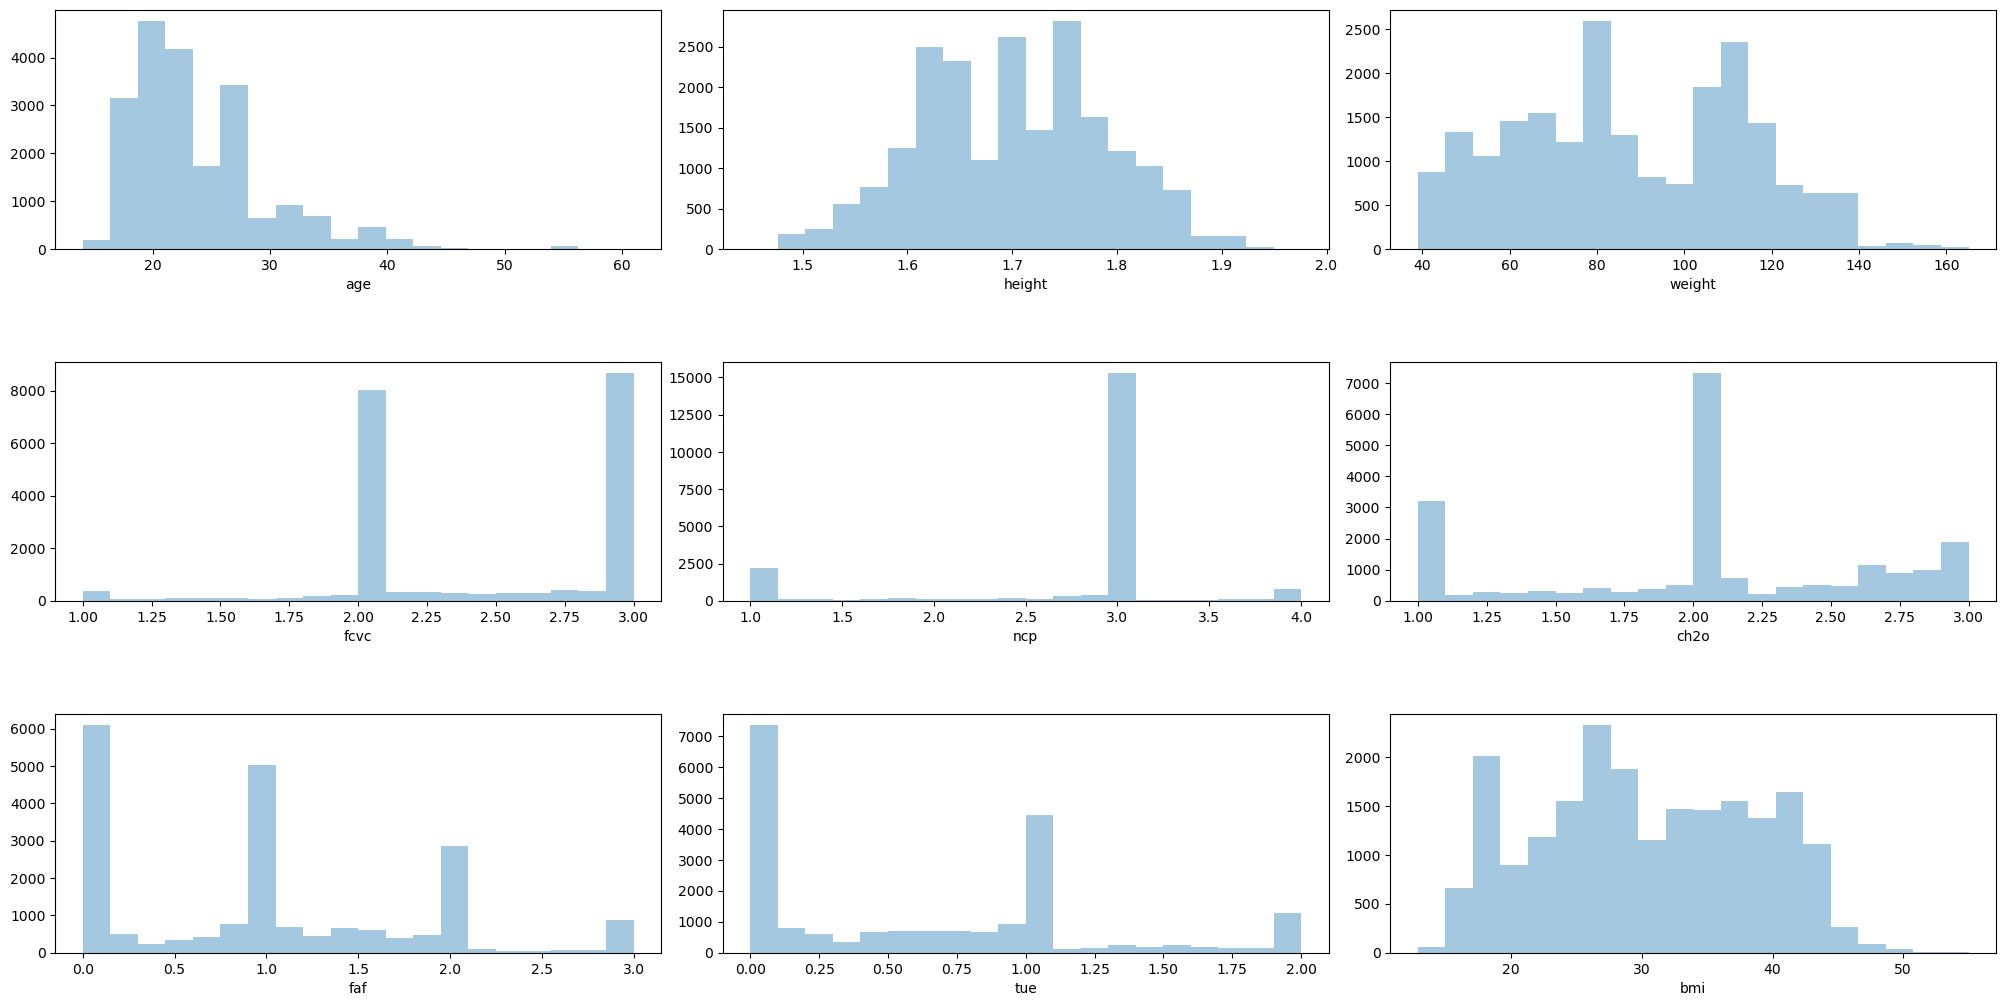

In [120]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
for num_col in ['age', 'height', 'weight', 'fcvc', 'ncp', 'ch2o', 'faf', 'tue', 'bmi']:
    num_unique_vals = df[num_col].nunique()
    num_bins = np.min([num_unique_vals, 20])
    sns.distplot(df[num_col], ax=axs[index], kde=False, bins=num_bins)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

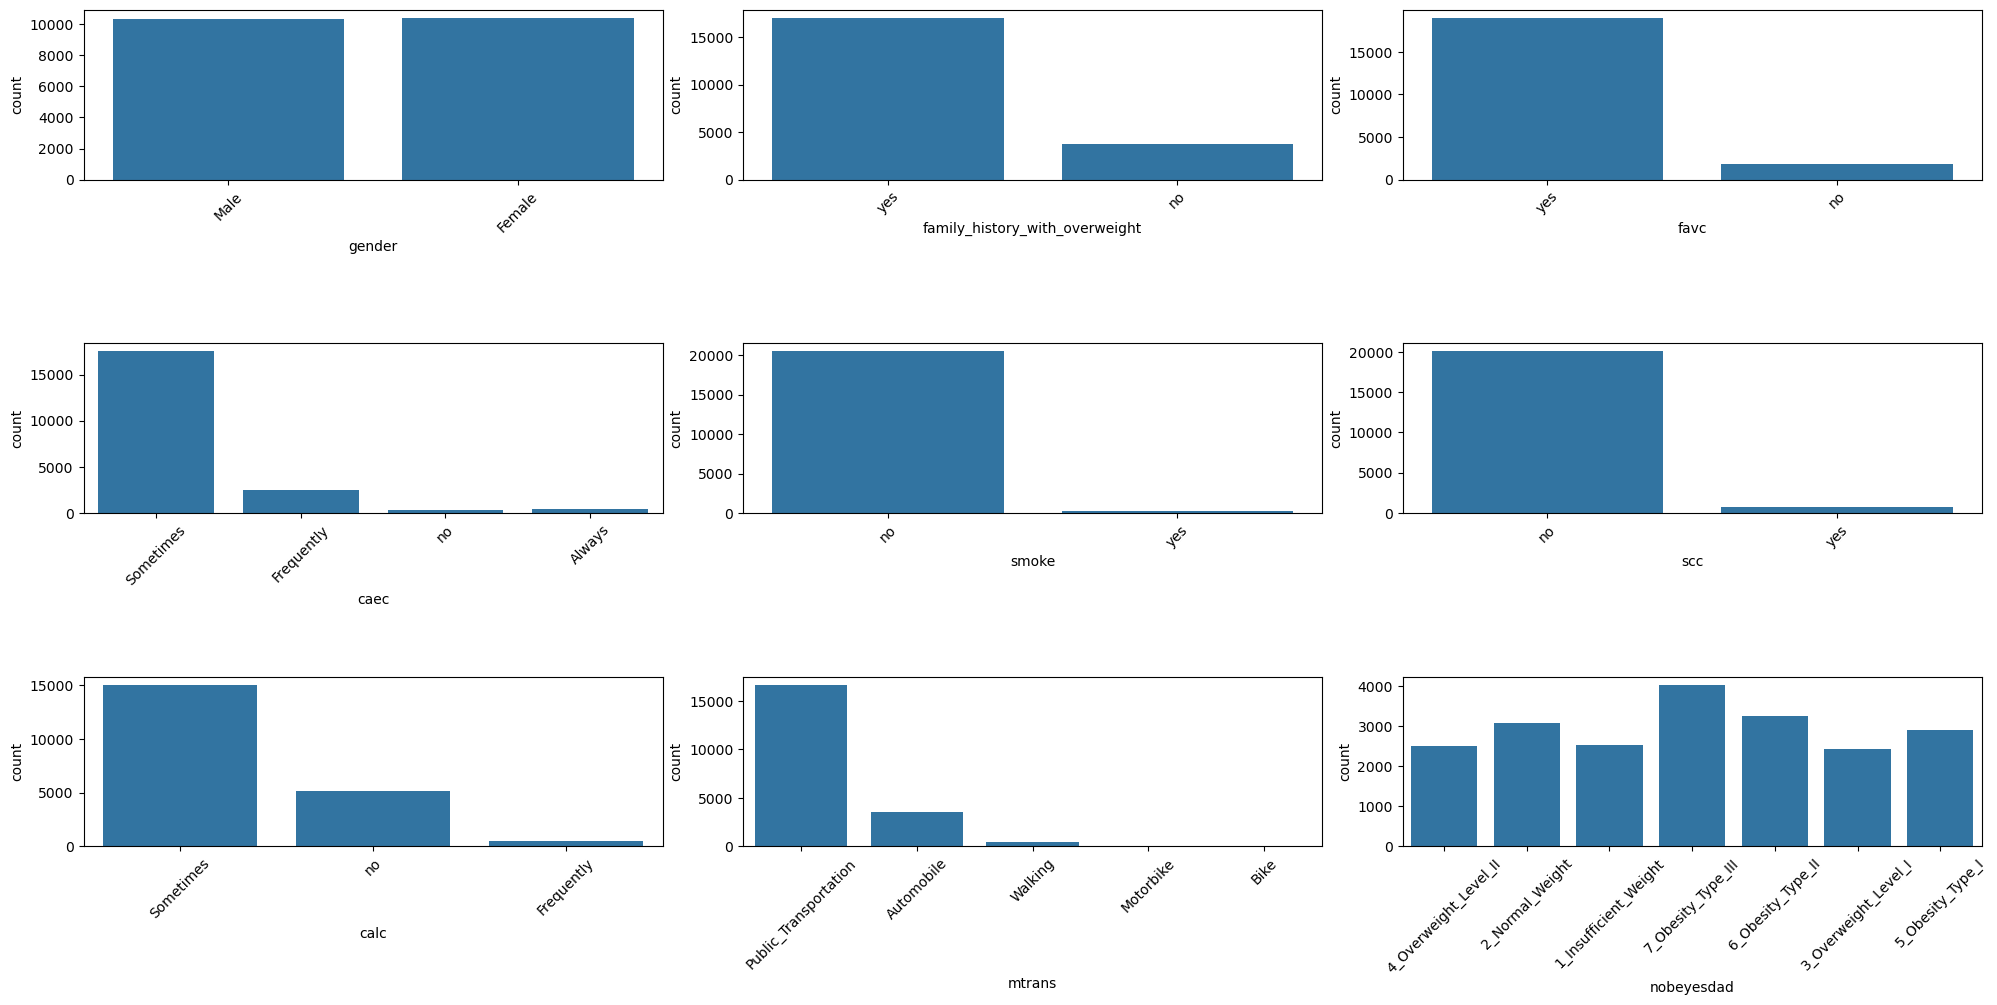

In [121]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
for num_col in ['gender', 'family_history_with_overweight', 'favc', 'caec', 'smoke', 'scc', 'calc', 'mtrans', 'nobeyesdad']:
    sns.countplot(x=num_col, data=df, ax=axs[index])
    axs[index].tick_params(axis='x', rotation=45)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

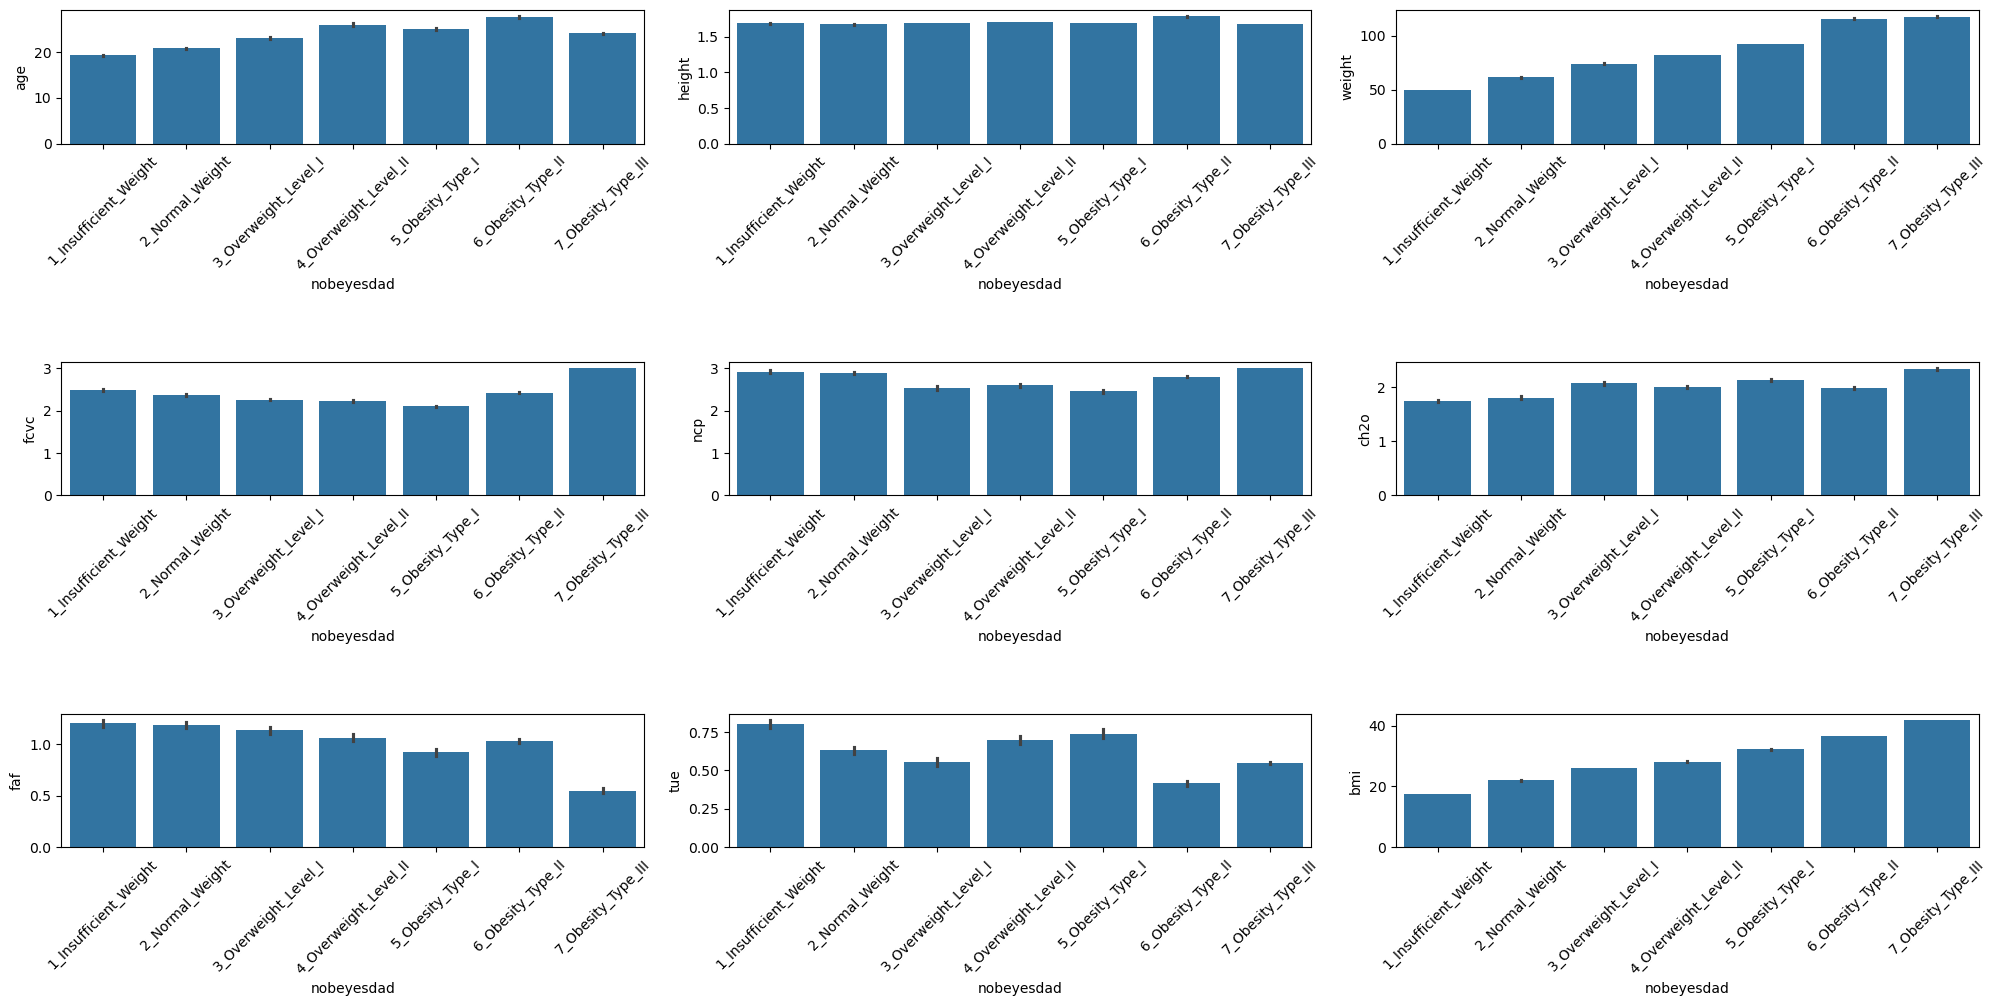

In [122]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 10))
index = 0
axs = axs.flatten()
sorted_nobeyesdad = sorted(df['nobeyesdad'].unique())
for num_col in ['age', 'height', 'weight', 'fcvc', 'ncp', 'ch2o', 'faf', 'tue', 'bmi']:
    sns.barplot(x='nobeyesdad', y=num_col, data=df, ax=axs[index], order=sorted_nobeyesdad)
    axs[index].tick_params(axis='x', rotation=45)
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

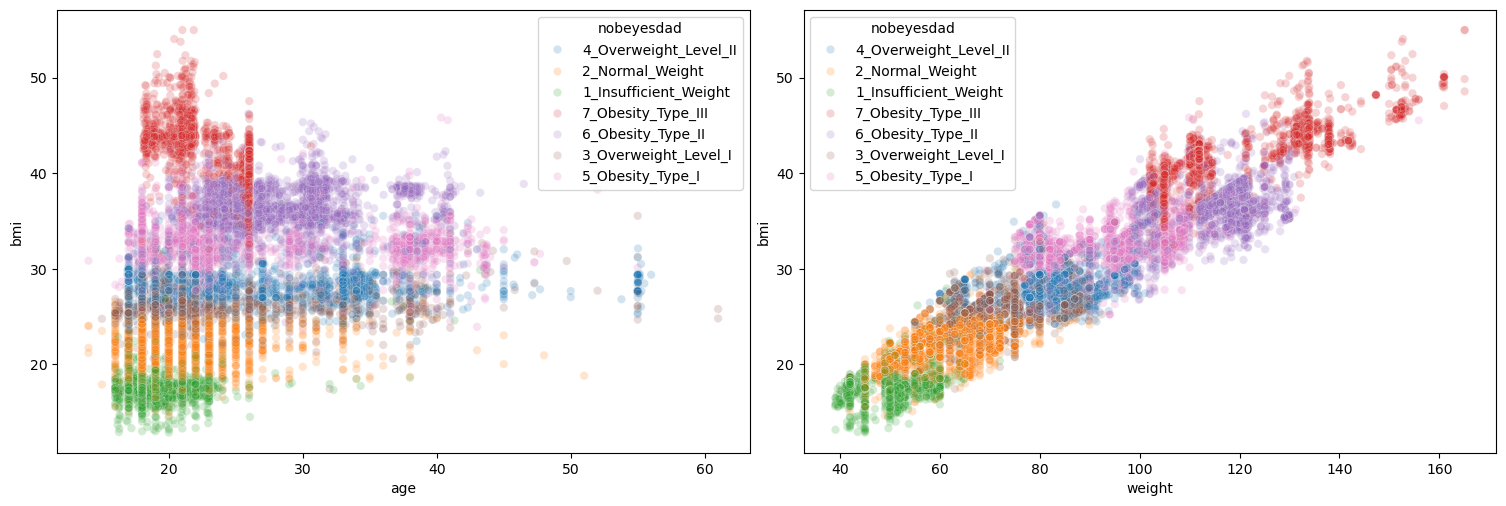

In [123]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
index = 0
axs = axs.flatten()
for num_col in ['age', 'weight']:
    sns.scatterplot(x=num_col, y="bmi", hue='nobeyesdad', data=df, alpha=0.2, ax=axs[index])
    index += 1
    
plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=5.0)

In [124]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='gender', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

gender,Female,Male
nobeyesdad,,
1_Insufficient_Weight,1621,902
2_Normal_Weight,1660,1422
3_Overweight_Level_I,1070,1357
4_Overweight_Level_II,755,1767
5_Obesity_Type_I,1267,1643
6_Obesity_Type_II,8,3240
7_Obesity_Type_III,4041,5


In [125]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='family_history_with_overweight', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

family_history_with_overweight,no,yes
nobeyesdad,,
1_Insufficient_Weight,1449,1074
2_Normal_Weight,1292,1790
3_Overweight_Level_I,756,1671
4_Overweight_Level_II,193,2329
5_Obesity_Type_I,48,2862
6_Obesity_Type_II,5,3243
7_Obesity_Type_III,1,4045


In [126]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='favc', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

favc,no,yes
nobeyesdad,,
1_Insufficient_Weight,370,2153
2_Normal_Weight,495,2587
3_Overweight_Level_I,224,2203
4_Overweight_Level_II,539,1983
5_Obesity_Type_I,93,2817
6_Obesity_Type_II,54,3194
7_Obesity_Type_III,1,4045


In [127]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='caec', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

caec,Always,Frequently,Sometimes,no
nobeyesdad,,,,
1_Insufficient_Weight,35,1212,1268,8
2_Normal_Weight,275,706,2065,36
3_Overweight_Level_I,60,273,1875,219
4_Overweight_Level_II,33,210,2273,6
5_Obesity_Type_I,64,56,2782,8
6_Obesity_Type_II,10,12,3224,2
7_Obesity_Type_III,1,3,4042,0


In [128]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='smoke', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

smoke,no,yes
nobeyesdad,,
1_Insufficient_Weight,2516,7
2_Normal_Weight,3036,46
3_Overweight_Level_I,2402,25
4_Overweight_Level_II,2497,25
5_Obesity_Type_I,2886,24
6_Obesity_Type_II,3134,114
7_Obesity_Type_III,4042,4


In [129]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='scc', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

scc,no,yes
nobeyesdad,,
1_Insufficient_Weight,2291,232
2_Normal_Weight,2922,160
3_Overweight_Level_I,2178,249
4_Overweight_Level_II,2498,24
5_Obesity_Type_I,2892,18
6_Obesity_Type_II,3244,4
7_Obesity_Type_III,4046,0


In [130]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='calc', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

calc,Frequently,Sometimes,no
nobeyesdad,,,
1_Insufficient_Weight,14,1620,889
2_Normal_Weight,68,1940,1074
3_Overweight_Level_I,130,1960,337
4_Overweight_Level_II,228,1279,1015
5_Obesity_Type_I,76,1444,1390
6_Obesity_Type_II,13,2777,458
7_Obesity_Type_III,0,4046,0


In [131]:
stats = pd.pivot_table(df, values='bmi', aggfunc='count', index='nobeyesdad', columns='mtrans', fill_value=0)
stats.style.background_gradient(cmap='coolwarm')

mtrans,Automobile,Bike,Motorbike,Public_Transportation,Walking
nobeyesdad,,,,,
1_Insufficient_Weight,277,2,4,2166,74
2_Normal_Weight,309,14,17,2565,177
3_Overweight_Level_I,475,9,7,1835,101
4_Overweight_Level_II,782,4,3,1649,84
5_Obesity_Type_I,747,2,4,2132,25
6_Obesity_Type_II,944,1,3,2294,6
7_Obesity_Type_III,0,0,0,4046,0


In [132]:
df.loc[df['nobeyesdad'] == '7_Obesity_Type_III']

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad,bmi
3,Female,20.952737,1.710730,131.274851,yes,yes,3.0,3.0,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,7_Obesity_Type_III,44.855798
9,Female,26.000000,1.638836,111.275646,yes,yes,3.0,3.0,Sometimes,no,2.632253,no,0.000000,0.218645,Sometimes,Public_Transportation,7_Obesity_Type_III,41.431355
13,Female,21.412538,1.729045,131.529267,yes,yes,3.0,3.0,Sometimes,no,1.959531,no,1.425712,0.947884,Sometimes,Public_Transportation,7_Obesity_Type_III,43.995657
22,Female,25.918524,1.663341,112.579220,yes,yes,3.0,3.0,Sometimes,no,2.724099,no,0.000000,0.081156,Sometimes,Public_Transportation,7_Obesity_Type_III,40.690746
26,Female,26.000000,1.611462,111.950113,yes,yes,3.0,3.0,Sometimes,no,2.609052,no,0.000000,0.079334,Sometimes,Public_Transportation,7_Obesity_Type_III,43.110633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20733,Female,26.000000,1.623303,105.037463,yes,yes,3.0,3.0,Sometimes,no,2.474518,no,0.000000,0.445495,Sometimes,Public_Transportation,7_Obesity_Type_III,39.860711
20737,Female,25.783865,1.633020,104.988925,yes,yes,3.0,3.0,Sometimes,no,1.322004,no,0.246290,0.723154,Sometimes,Public_Transportation,7_Obesity_Type_III,39.369553
20744,Female,26.000000,1.637524,111.946655,yes,yes,3.0,3.0,Sometimes,no,2.396977,no,0.000000,0.037078,Sometimes,Public_Transportation,7_Obesity_Type_III,41.748009
20749,Female,25.783865,1.646390,104.835346,yes,yes,3.0,3.0,Sometimes,no,1.530992,no,0.015860,0.445495,Sometimes,Public_Transportation,7_Obesity_Type_III,38.676066


<h2>Encoding</h2>

In [134]:
def encode_binary(df):
    """
    Encode binary features.

    Arguments:
        df (pandas.DataFrame): training dataset.

    Returns:
        training dataset with encoded binary features as a pandas.DataFrame.
    """
    yes_no_features = ['family_history_with_overweight', 'favc', 'smoke', 'scc']
    for feature in yes_no_features:
        df[feature] = df[feature].map({'yes': 1, 'no': 0})

    df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

    return df

In [392]:
def encode_one_hot(df):
    """
    Apply one-hot encoding for binary features features.

    Arguments:
        df (pandas.DataFrame): training dataset.

    Returns:
        training dataset with one-hot encoded categorical features as a pandas.DataFrame.
    """
    df = df.copy(deep=True)
    df = encode_binary(df=df)

    multi_class_cols = ['caec', 'calc', 'mtrans']
    for multi_class_col in multi_class_cols:
        feat_encoded_df = pd.get_dummies(df[multi_class_col], drop_first=True).astype(int)
        df = pd.concat([feat_encoded_df, df], axis=1).drop(columns=[multi_class_col])

    return df

In [373]:
def encode_label(df):
    """
    Apply label encoding for binary features features.

    Arguments:
        df (pandas.DataFrame): training dataset.

    Returns:
        training dataset with label encoded categorical features as a pandas.DataFrame.
    """
    df = df.copy(deep=True)
    df = encode_binary(df=df)

    df['caec'] = df['caec'].map({'no': 1, 'Sometimes': 1, 'Frequently': 2, 'Always': 3})
    df['calc'] = df['calc'].map({'no': 1, 'Sometimes': 1, 'Frequently': 2})
    df['mtrans'] = df['mtrans'].map({'Automobile': 0, 'Public_Transportation': 1, 'Motorbike': 2, 'Bike': 3, 'Walking': 4})

    return df

In [375]:
encoded_df = encode_label(df=df)
encoded_df['nobeyesdad_int'] = encoded_df['nobeyesdad'].map(lambda x: int(x[0]))

In [377]:
encoded_df

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad,bmi,nobeyesdad_int
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,1,4_Overweight_Level_II,28.259565,4
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,1,0,2_Normal_Weight,23.422091,2
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,1,1,1_Insufficient_Weight,17.126706,1
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,1,7_Obesity_Type_III,44.855798,7
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,1,4_Overweight_Level_II,25.599151,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,1,25.137087,1.766626,114.187096,1,1,2.919584,3.000000,1,0,2.151809,0,1.330519,0.196680,1,1,6_Obesity_Type_II,36.587084,6
20754,1,18.000000,1.710000,50.000000,0,1,3.000000,4.000000,2,0,1.000000,0,2.000000,1.000000,1,1,1_Insufficient_Weight,17.099278,1
20755,1,20.101026,1.819557,105.580491,1,1,2.407817,3.000000,1,0,2.000000,0,1.158040,1.198439,1,1,6_Obesity_Type_II,31.889841,6
20756,1,33.852953,1.700000,83.520113,1,1,2.671238,1.971472,1,0,2.144838,0,0.000000,0.973834,1,0,4_Overweight_Level_II,28.899693,4


In [379]:
encoded_df.drop(columns=['nobeyesdad']).corr().round(3).style.background_gradient(cmap='coolwarm').format("{:.3f}")

,gender,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,bmi,nobeyesdad_int
gender,1.000,0.067,0.624,0.119,0.096,0.022,-0.313,0.039,-0.042,0.063,0.053,-0.061,0.238,0.059,0.055,-0.042,-0.091,-0.068
age,0.067,1.000,-0.012,0.283,0.262,0.057,0.034,-0.048,-0.172,0.056,-0.016,-0.109,-0.192,-0.296,0.036,-0.429,0.321,0.356
height,0.624,-0.012,1.000,0.417,0.228,0.116,-0.072,0.191,-0.093,0.070,0.184,-0.096,0.295,0.076,0.038,-0.002,0.098,0.150
weight,0.119,0.283,0.417,1.000,0.514,0.229,0.246,0.096,-0.376,0.040,0.318,-0.185,-0.085,-0.086,-0.048,-0.076,0.941,0.921
family_history_with_overweight,0.096,0.262,0.228,0.514,1.000,0.152,0.048,0.045,-0.251,0.019,0.192,-0.167,-0.094,0.006,-0.017,-0.131,0.499,0.522
favc,0.022,0.057,0.116,0.229,0.152,1.000,0.007,0.012,-0.125,-0.016,0.039,-0.112,-0.067,0.035,-0.045,-0.101,0.216,0.215
fcvc,-0.313,0.034,-0.072,0.246,0.048,0.007,1.000,0.113,-0.009,-0.012,0.101,0.022,-0.090,-0.148,-0.037,0.053,0.297,0.273
ncp,0.039,-0.048,0.191,0.096,0.045,0.012,0.113,1.000,0.062,0.007,0.081,0.007,0.101,0.067,-0.003,0.029,0.049,0.027
caec,-0.042,-0.172,-0.093,-0.376,-0.251,-0.125,-0.009,0.062,1.000,0.018,-0.127,0.109,0.101,0.038,0.080,0.093,-0.384,-0.402
smoke,0.063,0.056,0.070,0.040,0.019,-0.016,-0.012,0.007,0.018,1.000,-0.023,0.017,0.008,-0.016,0.008,-0.007,0.013,0.014


In [381]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [383]:
def calc_vif(df, drop_feat=None):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the dataset.

    Arguments:
        df (pandas.DataFrame): DataFrame containing the feature set (independent variables).

    Returns:
        pandas.DataFrame: DataFrame containing the VIF for each feature.
    """
    df = encode_label(df=df)
    df = df.drop(columns=['nobeyesdad'])
    if drop_feat is not None:
        df = df.drop(columns=drop_feat)
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [385]:
vif_result = calc_vif(df=df)
vif_result

,feature,VIF
0,gender,3.681303
1,age,28.904172
2,height,161.427012
3,weight,194.121541
4,family_history_with_overweight,7.981550
5,favc,12.732084
6,fcvc,28.367629
7,ncp,17.563537
8,caec,10.139839
9,smoke,1.027268


In [387]:
vif_result = calc_vif(df=df, drop_feat=['weight', 'height',])
vif_result

,feature,VIF
0,gender,2.421755
1,age,23.229444
2,family_history_with_overweight,7.913318
3,favc,11.574073
4,fcvc,25.332091
5,ncp,16.299052
6,caec,9.288900
7,smoke,1.021551
8,ch2o,13.512292
9,scc,1.088218


<h2>Abstract Class</h2>

In [414]:
class AbstractClassifier(ABC, ClassifierMixin, BaseEstimator):
    def __init__(self):
        self.classes = None
        self.cv_accuracy_df = None
        self.cv_test_target_bins = None
        self.cv_predictions_probabilities = None
        self.cv_eval_result = None
        self.scaler = StandardScaler()
        self.model = self._init_algo()

    @abstractmethod
    def _process_df(self, df):
        pass
        
    @abstractmethod
    def _init_algo(self):
        pass

    def fit(self, X, y):
        X = self._process_df(df=X)

        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        self.model = self._init_algo()
        self.model.fit(X_scaled, y)
        
    def predict(self, X):
        X = self._process_df(df=X)
        X_scaled = self.scaler.ransform(X)
        predictions = self.model.predict(X_scaled)

        return predictions

    def predict_proba(self, X):
        X = self._process_df(df=X)
        X_scaled = self.scaler.ransform(X)
        predictions = self.model.predict_proba(X_scaled)

        return predictions
        

    def run_cv(self, df, n_splits=5):

        target = df['nobeyesdad']
        self.classes = sorted(list(target.unique()))
        df = df.drop(columns=['nobeyesdad'])
        # df = self._process_df(df=df)
        
        accuracy_dfs = []
        test_target_bins = []
        predictions_probabilities = []
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_ix, test_ix in kf.split(df, target):
            train_df = df.iloc[train_ix]
            train_target = target.iloc[train_ix]

            test_df = df.iloc[test_ix]
            test_target = target.iloc[test_ix]
            
            # scaler = StandardScaler()
            # train_df_scaled = scaler.fit_transform(train_df)
            # test_df_scaled = scaler.transform(test_df)

            # clf = self._init_algo()
            # clf.fit(train_df_scaled, train_target)
            # predictions = clf.predict(test_df_scaled)
            # iter_predictions_probabilities = clf.predict_proba(test_df_scaled)
            self.fit(X=train_df, y=train_target)
            predictions = self.predict(X=test_df)
            iter_predictions_probabilities = self.predict_proba(X=test_df)
            predictions_probabilities.append(iter_predictions_probabilities)
      
            iter_accuracy_df = test_target.to_frame()
            iter_accuracy_df['prediction'] = predictions
            accuracy_dfs.append(iter_accuracy_df)

            iter_test_target_bin = label_binarize(test_target, classes=self.classes)
            test_target_bins.append(iter_test_target_bin)

        
        self.cv_accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)
        self.cv_test_target_bins = np.concatenate(test_target_bins, axis=0)
        self.cv_predictions_probabilities = np.concatenate(predictions_probabilities, axis=0)      

        eval_output = self.calc_metrics(df=self.cv_accuracy_df)
        roc_auc = roc_auc_score(self.cv_test_target_bins, self.cv_predictions_probabilities, average='weighted', multi_class='ovr')
        eval_output['roc_auc_score'] = roc_auc
        self.cv_eval_result = eval_output

        return eval_output

    
    def draw_roc(self):
        y_true = self.cv_test_target_bins
        y_scores = self.cv_predictions_probabilities

        n_classes = y_scores.shape[1]

        fig = plt.figure(figsize=(20, 10))
            

        for i, class_name in enumerate(self.classes):
            ax = fig.add_subplot(2, 4, i+1)
            fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.3f})')

            ax.plot([0, 1], [0, 1], 'k--')

            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'ROC Curve for {class_name} class')
            ax.legend(loc="lower right")
            ax.grid()

        ax = fig.add_subplot(2, 4, 8)
        fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f'Micro-average ROC curve (AUC = {roc_auc:.3f})', color='blue')

        ax.plot([0, 1], [0, 1], 'k--')

        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'Micro-average ROC curve')
        ax.legend(loc="lower right")
        ax.grid()

        return fig

    def draw_conf_matrix(self):
        disp = ConfusionMatrixDisplay(self.cv_eval_result['confusion_matrix'])

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(1, 1, 1)
        disp.plot(ax=ax, cmap='Blues', colorbar=False)
        ax.set_title('Confusion Matrix')
        ax.grid(False)

        return fig
        

    @staticmethod
    def calc_metrics(df):
        y_true = df['nobeyesdad']
        y_pred = df['prediction']

        conf_mat = confusion_matrix(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)

        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        output = {
            'confusion_matrix': conf_mat,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
        }

        return output

<h2>Logistic Regression</h2>

In [417]:
lr_df = df.copy(deep=True)
lr_df = encode_one_hot(df=lr_df)
lr_df = lr_df.drop(columns=['weight', 'height'])

In [419]:
train_df, test_df = train_test_split(lr_df, test_size=0.2)

train_target = train_df['nobeyesdad']
train_df = train_df.drop(columns=['nobeyesdad'])

test_target = test_df['nobeyesdad']
test_df = test_df.drop(columns=['nobeyesdad'])

In [421]:
scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)
test_df_scaled = scaler.transform(test_df)

# Train multinomial logistic regression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
clf.fit(train_df_scaled, train_target)

# Predict and evaluate
pred = clf.predict(test_df_scaled)
print(classification_report(test_target, pred))

                       precision    recall  f1-score   support

1_Insufficient_Weight       0.88      0.93      0.91       507
      2_Normal_Weight       0.82      0.80      0.81       617
 3_Overweight_Level_I       0.70      0.65      0.67       497
4_Overweight_Level_II       0.70      0.70      0.70       515
     5_Obesity_Type_I       0.80      0.77      0.79       575
    6_Obesity_Type_II       0.90      0.94      0.92       640
   7_Obesity_Type_III       0.99      1.00      0.99       801

             accuracy                           0.84      4152
            macro avg       0.83      0.83      0.83      4152
         weighted avg       0.84      0.84      0.84      4152



In [ ]:
class LRClassifier(AbstractClassifier):
    def __init__(self):
        super().__init__()

    @staticmethod
    def _process_df(df):
        df = df.copy(deep=True)
        df = encode_one_hot(df=df)
        # df = df.drop(columns=['weight', 'height'])
        # df = df.drop(columns=['bmi'])

        return df

    
    def _init_algo(self):
        return LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

In [423]:
# class LRClassifier(ClassifierMixin, BaseEstimator):
#     def __init__(self):
#         self.classes = None
#         self.cv_accuracy_df = None
#         self.cv_test_target_bins = None
#         self.cv_predictions_probabilities = None
#         self.cv_eval_result = None

#     @staticmethod
#     def _process_df(df):
#         df = df.copy(deep=True)
#         df = encode_one_hot(df=df)
#         # df = df.drop(columns=['weight', 'height'])
#         # df = df.drop(columns=['bmi'])

#         return df

    
#     def _init_algo(self):
#         return LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)

#     def run_cv(self, df, n_splits=5):
#         df = self._process_df(df=df)

#         target = df['nobeyesdad']
#         self.classes = sorted(list(target.unique()))
#         df = df.drop(columns=['nobeyesdad'])
        
#         accuracy_dfs = []
#         test_target_bins = []
#         predictions_probabilities = []
#         kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
#         for train_ix, test_ix in kf.split(df, target):
#             train_df = df.iloc[train_ix]
#             train_target = target.iloc[train_ix]

#             test_df = df.iloc[test_ix]
#             test_target = target.iloc[test_ix]
            
#             scaler = StandardScaler()
#             train_df_scaled = scaler.fit_transform(train_df)
#             test_df_scaled = scaler.transform(test_df)

#             clf = self._init_algo()
#             clf.fit(train_df_scaled, train_target)
#             predictions = clf.predict(test_df_scaled)
#             iter_predictions_probabilities = clf.predict_proba(test_df_scaled)
#             predictions_probabilities.append(iter_predictions_probabilities)
      
#             iter_accuracy_df = test_target.to_frame()
#             iter_accuracy_df['prediction'] = predictions
#             accuracy_dfs.append(iter_accuracy_df)

#             iter_test_target_bin = label_binarize(test_target, classes=self.classes)
#             test_target_bins.append(iter_test_target_bin)

        
#         self.cv_accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)
#         self.cv_test_target_bins = np.concatenate(test_target_bins, axis=0)
#         self.cv_predictions_probabilities = np.concatenate(predictions_probabilities, axis=0)      

#         eval_output = self.calc_metrics(df=self.cv_accuracy_df)
#         roc_auc = roc_auc_score(self.cv_test_target_bins, self.cv_predictions_probabilities, average='weighted', multi_class='ovr')
#         eval_output['roc_auc_score'] = roc_auc
#         self.cv_eval_result = eval_output

#         return eval_output

    
#     def draw_roc(self):
#         y_true = self.cv_test_target_bins
#         y_scores = self.cv_predictions_probabilities

#         n_classes = y_scores.shape[1]

#         fig = plt.figure(figsize=(20, 10))
            

#         for i, class_name in enumerate(self.classes):
#             ax = fig.add_subplot(2, 4, i+1)
#             fpr, tpr, _ = roc_curve(y_true[:, i], y_scores[:, i])
#             roc_auc = auc(fpr, tpr)
#             ax.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc:.3f})')

#             ax.plot([0, 1], [0, 1], 'k--')

#             ax.set_xlim([0.0, 1.0])
#             ax.set_ylim([0.0, 1.05])
#             ax.set_xlabel('False Positive Rate')
#             ax.set_ylabel('True Positive Rate')
#             ax.set_title(f'ROC Curve for {class_name} class')
#             ax.legend(loc="lower right")
#             ax.grid()

#         ax = fig.add_subplot(2, 4, 8)
#         fpr, tpr, _ = roc_curve(y_true.ravel(), y_scores.ravel())
#         roc_auc = auc(fpr, tpr)
#         ax.plot(fpr, tpr, label=f'Micro-average ROC curve (AUC = {roc_auc:.3f})', color='blue')

#         ax.plot([0, 1], [0, 1], 'k--')

#         ax.set_xlim([0.0, 1.0])
#         ax.set_ylim([0.0, 1.05])
#         ax.set_xlabel('False Positive Rate')
#         ax.set_ylabel('True Positive Rate')
#         ax.set_title(f'Micro-average ROC curve')
#         ax.legend(loc="lower right")
#         ax.grid()

#         return fig

#     def draw_conf_matrix(self):
#         disp = ConfusionMatrixDisplay(self.cv_eval_result['confusion_matrix'])

#         fig = plt.figure(figsize=(8, 6))
#         ax = fig.add_subplot(1, 1, 1)
#         disp.plot(ax=ax, cmap='Blues', colorbar=False)
#         ax.set_title('Confusion Matrix')
#         ax.grid(False)

#         return fig
        

#     @staticmethod
#     def calc_metrics(df):
#         y_true = df['nobeyesdad']
#         y_pred = df['prediction']

#         conf_mat = confusion_matrix(y_true, y_pred)
#         accuracy = accuracy_score(y_true, y_pred)

#         precision = precision_score(y_true, y_pred, average='macro')
#         recall = recall_score(y_true, y_pred, average='macro')
#         f1 = f1_score(y_true, y_pred, average='macro')

#         output = {
#             'confusion_matrix': conf_mat,
#             'accuracy': accuracy,
#             'precision': precision,
#             'recall': recall,
#             'f1_score': f1,
#         }

#         return output

In [425]:
lr = LRClassifier()
eval_res = lr.run_cv(df=df)

In [427]:
eval_res

{'confusion_matrix': array([[2369,  144,    7,    2,    0,    1,    0],
        [ 304, 2501,  242,   31,    4,    0,    0],
        [  14,  243, 1704,  403,   63,    0,    0],
        [   0,   41,  312, 1791,  353,   23,    2],
        [   3,    3,   52,  229, 2416,  185,   22],
        [   0,    0,    1,   20,   99, 3128,    0],
        [   1,    0,    4,    0,    0,    4, 4037]]),
 'accuracy': 0.8645341555063109,
 'precision': 0.8491489842418828,
 'recall': 0.8505385647627242,
 'f1_score': 0.8495464117235751,
 'roc_auc_score': 0.9819969355579358}

In [411]:
eval_res

{'confusion_matrix': array([[2370,  144,    5,    3,    0,    1,    0],
        [ 297, 2510,  238,   33,    4,    0,    0],
        [  15,  236, 1711,  398,   67,    0,    0],
        [   0,   45,  313, 1787,  354,   23,    0],
        [   3,    3,   48,  235, 2420,  181,   20],
        [   0,    0,    2,   20,  102, 3124,    0],
        [   1,    0,    4,    0,    0,    4, 4037]]),
 'accuracy': 0.8651604200790057,
 'precision': 0.8498749295503574,
 'recall': 0.8512182440453243,
 'f1_score': 0.8502633717589687,
 'roc_auc_score': 0.9819795384543714}

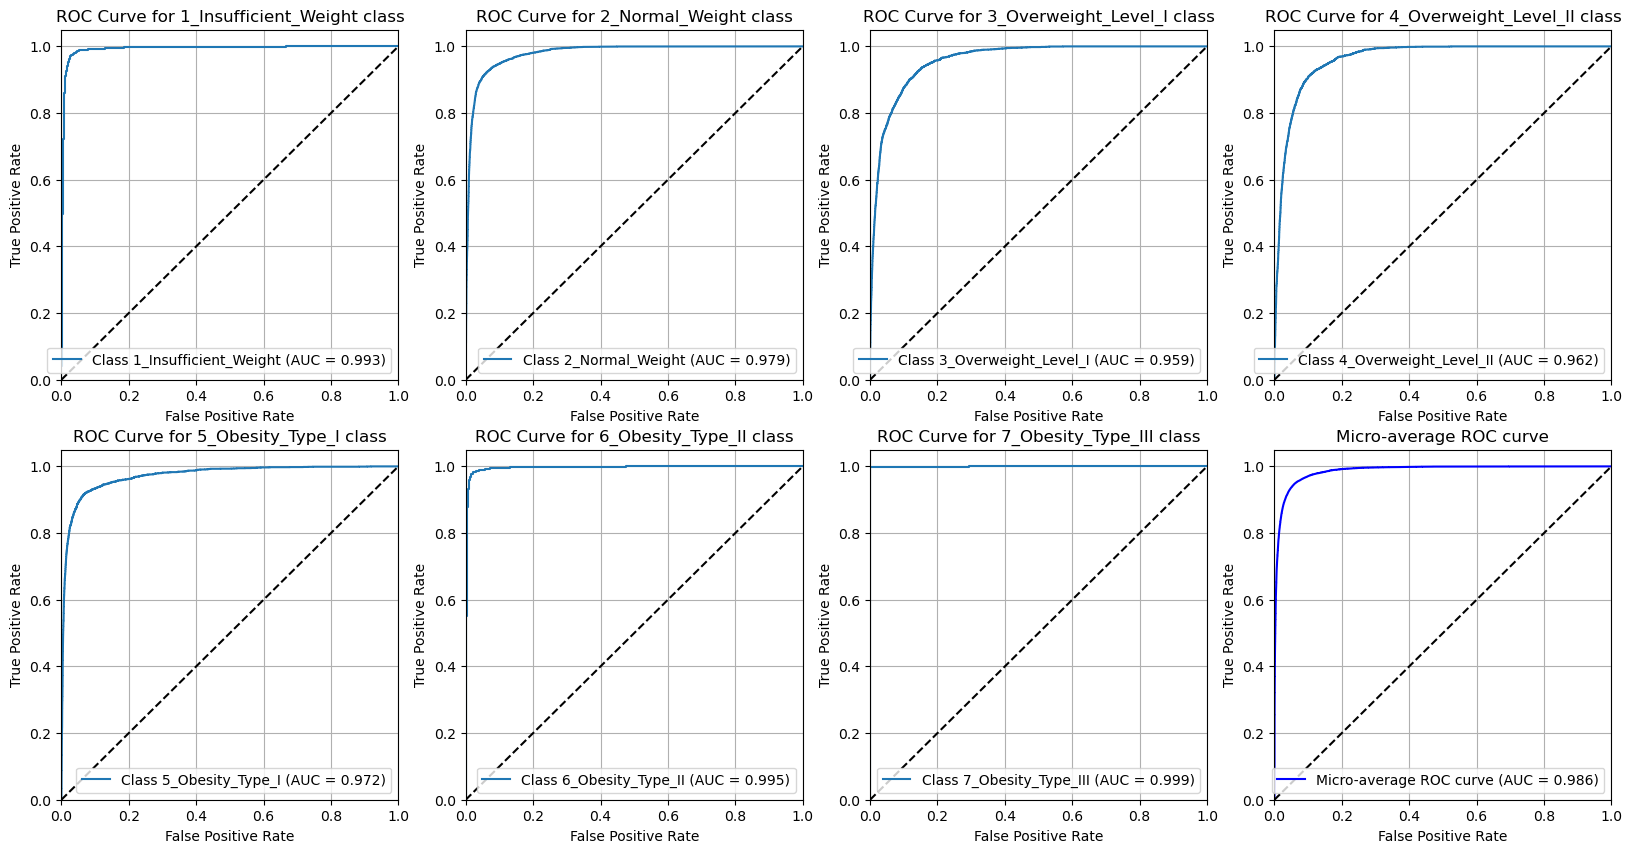

In [330]:
_ = lr.draw_roc()